<a href="https://colab.research.google.com/github/AvonleaFisher/Analyzing-NYC-311-Service-Requests/blob/main/Modeling_the_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction 

The aim of this section is to train a neural network that can accurately classify the agency that responded to a 311 call, given the call's descriptor. In the exploratory analysis section, we saw that none of the community districts' numeric indicators were highly correlated with any of the dummy-encoded agency categories. Intuitively, one may expect the call's descriptor to be the best predictor of the responding agency, but given that the descriptors consist of natural language data, they will need to undergo additional preprocessig before being fed into a model.

# Loading Dependencies and Importing the Data

In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import random
import re

from sklearn import preprocessing
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.preprocessing.text import Tokenizer
from keras import models
from keras import layers
from keras import optimizers
from keras.utils.np_utils import to_categorical

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks/community_board_311.csv'
df = pd.read_csv(path, index_col=0)

/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


# Assessing Model Performance

With perfectly balanced classes, a model's accuracy is acceptable if it exceeds the expected accuracy rate of simply picking a random class. With heavily imbalanced classes, however, a model's accuracy can instead be compared to that of picking the majority class. Below is the expected accuracy rate if we were to predict that all calls in a sample were responded to by the NYPD.

In [ ]:
len(df[df.agency =='NYPD'])/sum(df.agency.value_counts()) * 100

53.560233979566185

While the aim will be to maximize model accuracy, any classifier that is at least 54% accurate will out-perform the simple assignment of all calls to the NYPD.

# Sampling the Data 
The dataset currently consists of more than one million rows:

In [ ]:
len(df)

1332595

Retrieving the training data from a representative sample, rather than the entire dataset, will save time in the training process and ideally not result in a significant decline in accuracy.

In training classification models, we'll want to ensure that complaint descriptors from every agency category are represented. This way, the model will also be able to recognize encoded descriptors that correspond to agencies that rarely receive calls. However, training a model on samples of equal length from each agency may lead to confusion when it is presented with new, imbalanced data. We'll oversample the minority classes, but ensure that the largest samples are those agencies that receive the most calls. This will allow the diversity of descriptors associated with each agency to be captured in the samples. Below, we create and print a dictionary with the class weights.

In [ ]:
weights_dict = {}

for agency, count in list(zip(df.agency.value_counts().index, df.agency.value_counts().values)):
  weight = count/len(df)
  weights_dict[agency] = weight
weights_dict

{'DCA': 0.007892870677137466,
 'DEP': 0.05711937985659559,
 'DOB': 0.031156502913488343,
 'DOE': 0.00031142245018178817,
 'DOHMH': 0.02230084909518646,
 'DOITT': 0.00011031108476318762,
 'DOT': 0.058726769948859184,
 'DPR': 0.08548958986038518,
 'DSNY': 0.04380100480641155,
 'EDC': 0.004075506811897088,
 'HPD': 0.11758561303321714,
 'NYPD': 0.5356023397956619,
 'OSE': 0.03240144229867289,
 'TLC': 0.0034263973675422764}

In [ ]:
df.agency.value_counts()

NYPD     713741
HPD      156694
DPR      113923
DOT       78259
DEP       76117
DSNY      58369
OSE       43178
DOB       41519
DOHMH     29718
DCA       10518
EDC        5431
TLC        4566
DOE         415
DOITT       147
Name: agency, dtype: int64

Next, we'll create a new dictionary with guidelines for the number of samples to be drawn from each class. The class weights are multiplied by a term that results in the largest sample, NYPD, consisting of around 60k calls.

In [ ]:
n_samples_dict = {}

for agency, weight in zip(weights_dict.keys(), weights_dict.values()):
  n_samples = int(15**4.3 * weight)
  n_samples_dict[agency] = n_samples

In [ ]:
n_samples_dict

{'DCA': 900,
 'DEP': 6515,
 'DOB': 3554,
 'DOE': 35,
 'DOHMH': 2543,
 'DOITT': 12,
 'DOT': 6699,
 'DPR': 9752,
 'DSNY': 4996,
 'EDC': 464,
 'HPD': 13413,
 'NYPD': 61099,
 'OSE': 3696,
 'TLC': 390}

The below function returns weighted samples of an agency that's passed in. Agencies that appear in fewer than 500 rows are sampled with replacement, such
that the minimum sample size is 500.

In [ ]:
def get_weighted_sample(agency):
  
  """Takes in an agency name as a string, and creates a subset with all rows
     with a match in the agency column. If the number of rows is greater than 
     500, a weighted sample is returned. Otherwise, a sample of lenth 500, with 
     replacement, is returned."""

  agency_subset = df[df.agency == agency]

  n_samples = n_samples_dict[agency]
  
  if len(agency_subset) > 415:
    weighted_sample = agency_subset.sample(n=n_samples, random_state=7)
  elif 416 > len(agency_subset) > 147:
    weighted_sample = agency_subset.sample(n=415, random_state=7)
  else:
    weighted_sample = agency_subset.sample(n=147, random_state=7)
  return weighted_sample

The function is applied below to each unique agency to create a dataframe of samples. These are conatenated in 'weighted_df' and the index is reset.

In [ ]:
DCA = get_weighted_sample('DCA')
DEP = get_weighted_sample('DEP')
DOB = get_weighted_sample('DOB')
DOE = get_weighted_sample('DOE')
DOHMH = get_weighted_sample('DOHMH')
DOITT = get_weighted_sample('DOITT')
DOT = get_weighted_sample('DOT')
DPR = get_weighted_sample('DPR')
DSNY = get_weighted_sample('DSNY')
EDC = get_weighted_sample('EDC')
HPD = get_weighted_sample('HPD')
NYPD = get_weighted_sample('NYPD')
OSE = get_weighted_sample('OSE')
TLC = get_weighted_sample('TLC')

In [ ]:
weighted_df = pd.concat([DCA, DEP, DOB, DOE, DOHMH, 
                         DOITT, DOT, DPR, DSNY, EDC, HPD, NYPD, OSE, TLC])
weighted_df.reset_index(inplace=True)

In order for the model to be tested on new data, it should have exposure to every unique descriptor in the dataset. The below code creates a list of every item in the original dataframe's unique descriptors that is not found in the sample dataframe.

In [ ]:
descriptors_not_in_sample = []

for i in df.descriptor.unique():
  if i not in weighted_df.descriptor.unique():
    descriptors_not_in_sample.append(i)

descriptors_not_in_sample

['bingo hall',
 'oil, grease in water qd',
 'flavored tobacco',
 'street cavein *dep internal use only* sg',
 'allergy information',
 'smoking signs  "no smoking" signs not observed on construction site',
 'plate condition  antiskid',
 'indoor pool over capacity',
 'e street obstruction',
 'clear water with organisms insects, worms qe',
 'safety equipment signs',
 'beach pool sauna unpermitted',
 'ea storage of receptacles',
 'snake',
 'time clock maladjusted',
 'puddle on sidewalk',
 'hyd valve box defective  see comments *for dep use only* wv',
 'multiple st lts dayburning',
 'puddle on driveway',
 'wood pole knocked down',
 'bracket arm bent',
 'honorary',
 'arcade',
 'flood light lamp dayburning',
 'warning signal lamp',
 'detour',
 'fire alarm lamp out',
 'snow or ice',
 'defective water sampling station qss',
 'odor in sewer catch basin icb',
 'pedicab',
 'traffic camera',
 'cellar door defective',
 'outlet cover',
 'air: odor, nail salon ad',
 'flood light lamp cycling',
 'jewel

The list above captures many of the less common descriptors that were not captured in the sample data. Below, we create a dataframe with all calls that match these descriptors and concatenate them with the weighted sample dataframe.

In [ ]:
descriptors_not_in_sample_df = df[df.descriptor.isin(descriptors_not_in_sample)]

In [ ]:
weighted_df = pd.concat([DCA, DEP, DOB, DOE, DOHMH, DOITT, DOT, 
                         DPR, DSNY, EDC, HPD, NYPD, OSE, TLC,
                         descriptors_not_in_sample_df])
weighted_df.reset_index(inplace=True)

In [ ]:
#confirm that the number of unique descriptors is the same for both dataframes
len(weighted_df.descriptor.unique()) == len(df.descriptor.unique())

True

The classes remain imbalanced, but no agency is represented by only a handful of samples, as would have been the case with simple random sampling:

In [ ]:
weighted_df.agency.value_counts()

NYPD     61105
HPD      13418
DPR       9763
DOT       6989
DEP       6715
DSNY      5076
OSE       3696
DOB       3627
DOHMH     2742
DCA        974
EDC        464
DOE        415
TLC        407
DOITT      147
Name: agency, dtype: int64

# Keras Neural Network

## Preparing the Training and Test Data

Using the dataframe of weighted samples, we assign 'X' to the descriptor column and 'y' to the agency column. 

In [ ]:
X = weighted_df.descriptor
y = weighted_df.agency

The [Keras Tokenizer](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer) `fit_on_texts()` method, used below, "updates internal vocabulary based on a list of texts." In this case, the list of texts is all descriptors in the weighted sample. The `texts_to_matrix()` method converts the list of texts to a Numpy matrix. Specifying the mode "binary" means that only the presence or absence of each item in the tokenizer's vocabulary will be accounted for in the matrix.

In [ ]:
descriptors = X
tokenizer = Tokenizer() 

tokenizer.fit_on_texts(descriptors) 
descriptor_onehot = tokenizer.texts_to_matrix(descriptors)
word_index = tokenizer.word_index

The word index is a dictionary that contains words in the tokenizer's vocabulary as keys, and integers that correspond to the keys' frequency rank as values. The first ten items of the dictionary are printed below, and we can see that the most frequent words have the lowest values. The highest value in the dictionary is 1109.

In [ ]:
# reversed_word_index = dict(map(reversed, word_index.items()))
# list(reversed_word_index.items())[0:10]
print(list(word_index.items())[0:10])
print('Max:', max(word_index.values()))

[('music', 1), ('loud', 2), ('party', 3), ('access', 4), ('no', 5), ('blocked', 6), ('hydrant', 7), ('truck', 8), ('car', 9), ('in', 10)]
Max: 1109


The content and shape of the one-hot encoded descriptors are displayed below.

In [ ]:
display(descriptor_onehot)

print('Shape:', descriptor_onehot.shape)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Shape: (115538, 1110)


The number of rows is the same as the number of rows in X, and correspond to an individual call:

In [ ]:
X.shape

(115538,)

Each column corresponds to one of 1,110 words in the tokenizer's vocabulary. If the word for a column is present in a given call's descriptor, its value at the call's corresponding row will be '1.' Otherwise, it will be '0.'

The label encoder used below assigns a unique integer to each of the categories in the agency column. The [keras.utils.to_categorical
](https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical) method "converts a class vector (integers) to binary class matrix."

In [ ]:
agency = y

le = preprocessing.LabelEncoder() 
le.fit(agency)
agency_cat = le.transform(agency)  
agency_onehot = to_categorical(agency_cat)

Let's examine the content and shape of the encoded agency data:

In [ ]:
display(agency_onehot)
print('Shape:', agency_onehot.shape)

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

Shape: (115538, 14)


Each row corresponds to a call, and each column corresponds to an agency. The value in a given cell indicates whether the agency in its column either responded ('1'), or did not respond ('0'), to the call in its row.

Now that both X and y have been encoded, we'll create a random split of training and test data.

In [ ]:
test, train, label_test, label_train = train_test_split(descriptor_onehot, agency_onehot, test_size=.1, random_state=9)

## Baseline Model

In [ ]:
model1 = models.Sequential()

model1.add(layers.Dense(50, activation='relu', input_shape=(test.shape[1],)))
model1.add(layers.Dense(25, activation='relu'))
model1.add(layers.Dense(14, activation='softmax'))

opt = tf.keras.optimizers.SGD(learning_rate=0.001)
model1.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['acc'])

In [ ]:
history = model1.fit(train,
                    label_train,
                    epochs=65,
                    batch_size=32)

Epoch 1/65
362/362 [==============================] - 1s 2ms/step - loss: 2.5409 - acc: 0.5093
Epoch 2/65
362/362 [==============================] - 1s 2ms/step - loss: 2.3932 - acc: 0.5235
Epoch 3/65
362/362 [==============================] - 1s 2ms/step - loss: 2.2324 - acc: 0.5235
Epoch 4/65
362/362 [==============================] - 1s 2ms/step - loss: 2.0574 - acc: 0.5235
Epoch 5/65
362/362 [==============================] - 1s 2ms/step - loss: 1.8905 - acc: 0.5235
Epoch 6/65
362/362 [==============================] - 1s 2ms/step - loss: 1.7590 - acc: 0.5235
Epoch 7/65
362/362 [==============================] - 1s 2ms/step - loss: 1.6734 - acc: 0.5235
Epoch 8/65
362/362 [==============================] - 1s 2ms/step - loss: 1.6177 - acc: 0.5235
Epoch 9/65
362/362 [==============================] - 1s 2ms/step - loss: 1.5756 - acc: 0.5235
Epoch 10/65
362/362 [==============================] - 1s 2ms/step - loss: 1.5395 - acc: 0.5235
Epoch 11/65
362/362 [============================

In [ ]:
results = model1.evaluate(test, label_test, batch_size=32)

3250/3250 [==============================] - 5s 2ms/step - loss: 0.7609 - acc: 0.7924


In [ ]:
def plot_loss_acc(history):
  plt.figure(figsize=(10,7))
  plt.grid(color='g', linestyle='-', linewidth=.09)
  plt.plot(history.history['loss'], label='Loss', color='#D8A7B1', linewidth=4)
  plt.plot(history.history['acc'], label='Accuracy', color='#05234C', linewidth=4)
  
  title_font = {'fontsize': 14, 'family': 'serif','color': '#58508d', 'weight': 'bold'}
  plt.title('Loss vs Accuracy', fontdict=title_font)

  ax_font = {'fontsize': 12, 'family': 'serif', 'color': '#58508d', 'weight': 'bold'}
  plt.ylabel('Value', fontdict=ax_font)
  plt.xlabel('Epochs', fontdict=ax_font)

  plt.legend(loc="upper right")
  plt.show()

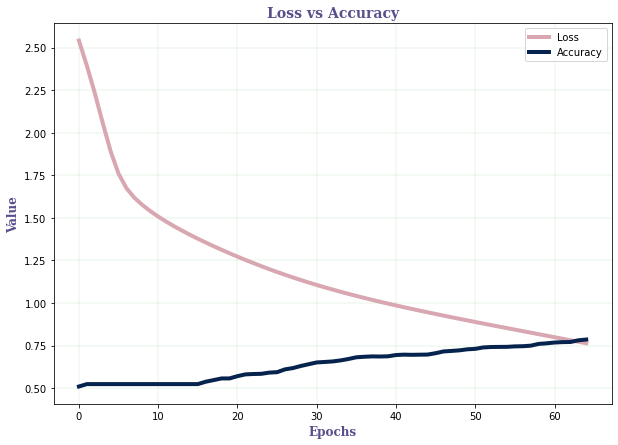

In [ ]:
plot_loss_acc(history)

In [ ]:
random_df = df.sample(len(weighted_df), random_state=9)

In [ ]:
descriptors_not_in_sample = []

for i in df.descriptor.unique():
  if i not in random_df.descriptor.unique():
    descriptors_not_in_sample.append(i)

descriptors_not_in_sample

['bingo hall',
 'sidewalk staircase',
 'safety inspectionretaining walls may ',
 'removing flowers plants',
 'plate condition  antiskid',
 'indoor pool over capacity',
 'e street obstruction',
 'safety equipment signs',
 'beach pool sauna unpermitted',
 'sewer',
 'time clock maladjusted',
 'hyd valve box defective  see comments *for dep use only* wv',
 'puddle on driveway',
 'deck inspection',
 'curb violation',
 'wood pole knocked down',
 'bracket arm bent',
 'arcade',
 'flood light lamp dayburning',
 'wifi internet not working slow',
 'snow or ice',
 'building',
 'boiler',
 'odor in sewer catch basin icb',
 'pedicab',
 'traffic camera',
 'glassware hanging',
 'outlet cover',
 'air: odor, nail salon ad',
 'flood light lamp cycling',
 'damaged leg or pole bent',
 'grocery store',
 'broken window',
 'no consent form',
 'immigration services',
 'sign  in danger of falling',
 'relocation of bus stop shelter',
 'request to open a hydrant wc',
 'tour company',
 'illegal use of hose  other c

In [ ]:
descriptors_not_in_sample_df = df[df.descriptor.isin(descriptors_not_in_sample)]
random_df = pd.concat([random_df, descriptors_not_in_sample_df])
random_df.reset_index(inplace=True)

In [ ]:
random_X = random_df.descriptor
random_y = random_df.agency

In [ ]:
r_descriptors = random_X
tokenizer = Tokenizer() 

tokenizer.fit_on_texts(r_descriptors) 
r_descriptor_onehot = tokenizer.texts_to_matrix(r_descriptors, mode='binary')
word_index = tokenizer.word_index

In [ ]:
r_agency = random_y

le = preprocessing.LabelEncoder() 
le.fit(r_agency)
r_agency_cat = le.transform(r_agency)  
r_agency_onehot = to_categorical(r_agency_cat)

In [ ]:
random.seed(888)
test_index = random.sample(range(1,10000), 1500)

r_test = r_descriptor_onehot[test_index]
r_label_test = r_agency_onehot[test_index]

In [ ]:
random_results = model1.evaluate(r_descriptor_onehot, r_agency_onehot, batch_size=32)

3640/3640 [==============================] - 6s 2ms/step - loss: 1.0035 - acc: 0.6595


## Parameter Tuning

In [ ]:
def create_model(X_train, y_train, X_test, y_test, params):
    
    model = models.Sequential()
    model.add(layers.Dense(50, activation=params['activation 1'], input_shape=(test.shape[1],)))
    model.add(layers.Dense(25, activation=params['activation 2']))
    model.add(layers.Dense(14, activation=params['activation 3']))

    opt = params['opt']
    model.compile(optimizer=opt,
              loss=params['loss'],
              metrics=['acc'])
    
    history = model.fit(X_train,
                    y_train,
                    epochs=params['epochs'],
                    batch_size=params['batch_size'])
    
    print(model.summary)

    plot_loss_acc(history)
    
    return history, model

In [ ]:
model2_params = {'activation 1': 'relu', 
                 'activation 2': 'softmax', 
                 'activation 3': 'softmax', 
                 'opt': keras.optimizers.Adam(lr=0.0001),
                 'loss': 'categorical_crossentropy',
                 'epochs': 70, 
                 'batch_size': 16, 
                 }

Epoch 1/70
723/723 [==============================] - 1s 2ms/step - loss: 2.5694 - acc: 0.3104
Epoch 2/70
723/723 [==============================] - 1s 2ms/step - loss: 2.2935 - acc: 0.5235
Epoch 3/70
723/723 [==============================] - 1s 2ms/step - loss: 2.0750 - acc: 0.5557
Epoch 4/70
723/723 [==============================] - 1s 2ms/step - loss: 1.9112 - acc: 0.6441
Epoch 5/70
723/723 [==============================] - 1s 2ms/step - loss: 1.7731 - acc: 0.7222
Epoch 6/70
723/723 [==============================] - 1s 2ms/step - loss: 1.6482 - acc: 0.7371
Epoch 7/70
723/723 [==============================] - 1s 2ms/step - loss: 1.5312 - acc: 0.7455
Epoch 8/70
723/723 [==============================] - 1s 2ms/step - loss: 1.4256 - acc: 0.7474
Epoch 9/70
723/723 [==============================] - 1s 2ms/step - loss: 1.3335 - acc: 0.7485
Epoch 10/70
723/723 [==============================] - 1s 2ms/step - loss: 1.2515 - acc: 0.7500
Epoch 11/70
723/723 [============================

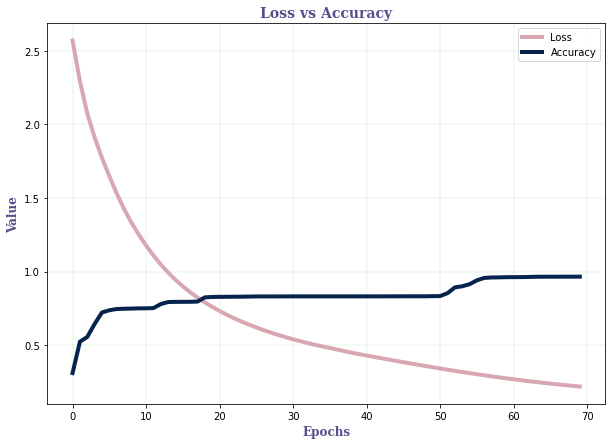

In [ ]:
model2_history, model2 = create_model(train, label_train, test, label_test, model2_params)

In [ ]:
model2.evaluate(test, label_test, batch_size=16)
model2.evaluate(r_test, r_label_test, batch_size=16)

94/94 [==============================] - 0s 2ms/step - loss: 1.7793 - acc: 0.6640


[1.779349446296692, 0.6639999747276306]

In [ ]:
model3_params = {'activation 1': 'relu', 
                 'activation 2': 'relu', 
                 'activation 3': 'softmax', 
                 'opt': tf.keras.optimizers.SGD(learning_rate=0.01),
                 'loss': 'categorical_crossentropy',
                 'epochs': 35, 
                 'batch_size': 16, 
                 }

Epoch 1/35
723/723 [==============================] - 1s 2ms/step - loss: 1.7692 - acc: 0.5170
Epoch 2/35
723/723 [==============================] - 1s 2ms/step - loss: 1.2269 - acc: 0.5805
Epoch 3/35
723/723 [==============================] - 1s 2ms/step - loss: 0.9764 - acc: 0.6978
Epoch 4/35
723/723 [==============================] - 1s 2ms/step - loss: 0.7969 - acc: 0.7633
Epoch 5/35
723/723 [==============================] - 1s 2ms/step - loss: 0.6425 - acc: 0.8350
Epoch 6/35
723/723 [==============================] - 1s 2ms/step - loss: 0.5072 - acc: 0.8795
Epoch 7/35
723/723 [==============================] - 1s 2ms/step - loss: 0.4034 - acc: 0.9037
Epoch 8/35
723/723 [==============================] - 1s 2ms/step - loss: 0.3309 - acc: 0.9260
Epoch 9/35
723/723 [==============================] - 1s 2ms/step - loss: 0.2795 - acc: 0.9405
Epoch 10/35
723/723 [==============================] - 1s 2ms/step - loss: 0.2424 - acc: 0.9452
Epoch 11/35
723/723 [============================

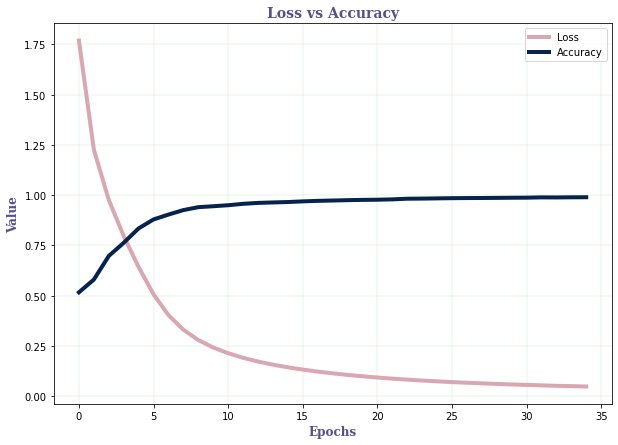

In [ ]:
model3_history, model3 = create_model(train, label_train, test, label_test, model3_params)

In [ ]:
model3.evaluate(test, label_test, batch_size=16)
model3.evaluate(r_test, r_label_test, batch_size=16)

94/94 [==============================] - 0s 2ms/step - loss: 1.6446 - acc: 0.6847


[1.6445579528808594, 0.6846666932106018]

In [ ]:
model4_params = {'activation 1': 'sigmoid', 
                 'activation 2': 'relu', 
                 'activation 3': 'softmax', 
                 'opt': tf.keras.optimizers.SGD(learning_rate=0.01),
                 'loss': 'categorical_crossentropy',
                 'epochs': 20, 
                 'batch_size': 1, 
                 }

Epoch 1/20
11554/11554 [==============================] - 17s 1ms/step - loss: 1.1594 - acc: 0.6370
Epoch 2/20
11554/11554 [==============================] - 16s 1ms/step - loss: 0.5466 - acc: 0.8536
Epoch 3/20
11554/11554 [==============================] - 16s 1ms/step - loss: 0.2642 - acc: 0.9347
Epoch 4/20
11554/11554 [==============================] - 16s 1ms/step - loss: 0.1661 - acc: 0.9564
Epoch 5/20
11554/11554 [==============================] - 16s 1ms/step - loss: 0.1195 - acc: 0.9681
Epoch 6/20
11554/11554 [==============================] - 16s 1ms/step - loss: 0.0950 - acc: 0.9751
Epoch 7/20
11554/11554 [==============================] - 16s 1ms/step - loss: 0.0753 - acc: 0.9804
Epoch 8/20
11554/11554 [==============================] - 16s 1ms/step - loss: 0.0639 - acc: 0.9839
Epoch 9/20
11554/11554 [==============================] - 16s 1ms/step - loss: 0.0538 - acc: 0.9865
Epoch 10/20
11554/11554 [==============================] - 16s 1ms/step - loss: 0.0497 - acc: 0.9878

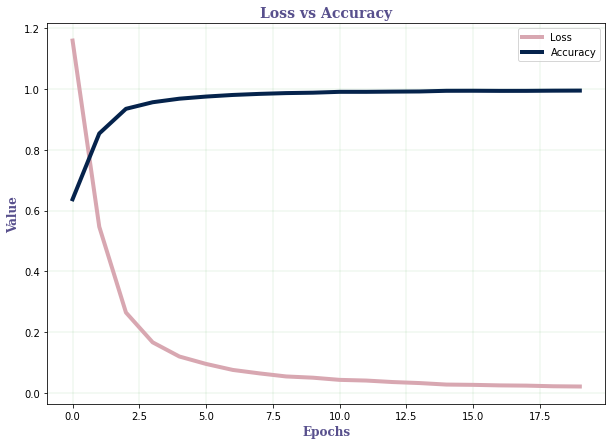

In [ ]:
model4_history, model4 = create_model(train, label_train, test, label_test, model4_params)

In [ ]:
model4.evaluate(test, label_test, batch_size=1)
model4.evaluate(r_test, r_label_test, batch_size=1)

1500/1500 [==============================] - 2s 1ms/step - loss: 2.9469 - acc: 0.6733


[2.946913480758667, 0.6733333468437195]

In [ ]:
label_preds = model3.predict_classes(r_descriptor_onehot)
label_preds_onehot = to_categorical(label_preds)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [ ]:
cf_matrix = confusion_matrix(r_agency_cat, label_preds)

Text(0.5, 96.0, 'Predicted Agency')

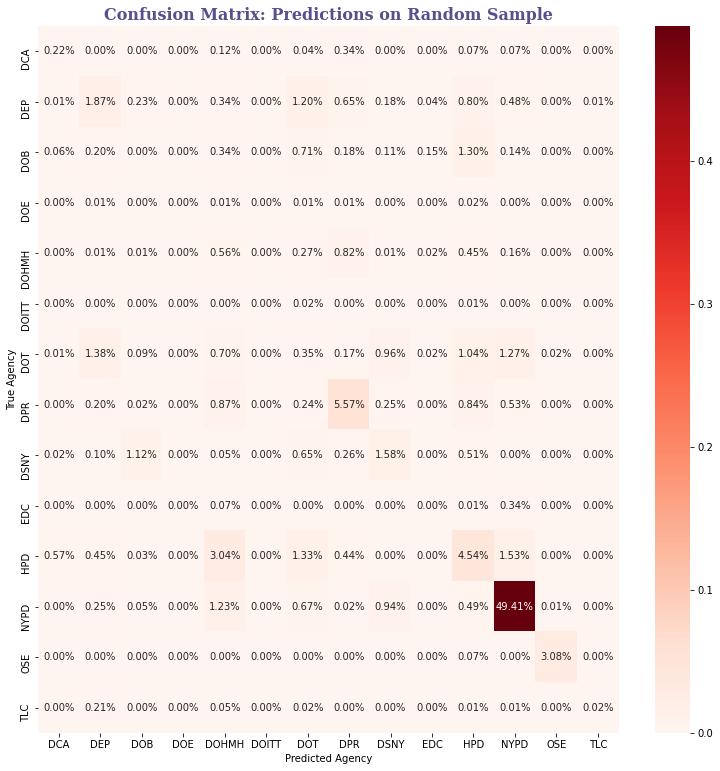

In [ ]:
plt.figure(figsize=(13, 13))
plt.title('Confusion Matrix: Predictions on Random Sample', 
          fontdict={'fontsize': 16, 'family': 'serif', 'color': '#58508d', 'weight': 'bold'})

sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, xticklabels=le.classes_, yticklabels=le.classes_,
            fmt='.2%', cmap='Reds')
plt.ylabel('True Agency')
plt.xlabel('Predicted Agency')

In [ ]:
# model3.save('/content/drive/MyDrive/Colab Notebooks')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/assets


# Random Forest

## Baseline Model

In [ ]:
descriptor_onehot.shape

(115538, 1110)

In [ ]:
X.shape

(115538,)

In [ ]:
X = weighted_df[['latitude', 'longitude', 'month', 
       'count_hosp_clinic', 'count_libraries', 'count_parks',
       'count_public_schools', 'crime_per_1000', 'female_20_24', 
       'female_30_34', 'female_40_44', 
       'female_45_49', 'female_50_54', 'female_55_59', 'female_60_64',
       'male_20_24', 'male_30_34',  
       'male_40_44', 'male_45_49', 'male_50_54', 'male_55_59', 
       'under18_rate', 'over65_rate', 'lots_total', 'lots_vacant', 
        'pct_white_nh', 'pct_black_nh', 'pct_asian_nh',
       'pct_other_nh', 'pct_hispanic', 'mean_commute', 'pop_change_00_10',
       'pct_clean_strts', 'unemployment', 'poverty_rate', 'lep_rate_boro',
       'pct_hh_rent_burd', 'hour', 'day_of_week']]

In [ ]:
X = pd.concat([X, pd.DataFrame(descriptor_onehot)], axis=1)

In [ ]:
X.shape

(115538, 1149)

In [ ]:
y = le.fit_transform(weighted_df.agency)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 9)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 42)
classifier.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [ ]:
from sklearn.metrics import plot_confusion_matrix
def plot_cm(X_train, X_test, y_train, y_test, y_test_preds, y_train_preds):

  fig, ax = plt.subplots(figsize=(10, 10))
  plot_confusion_matrix(classifier, X_test, y_test,
                                display_labels=list(le.classes_),
                                cmap='viridis', xticks_rotation='vertical',
                                normalize='true', ax=ax)
  plt.title('Random Forest Test Confusion Matrix', fontsize=17)
  plt.text(accuracy_score(y_test, y_test_preds))
  plt.show()

  fig, ax = plt.subplots(figsize=(10, 10))
  plot_confusion_matrix(classifier, X_train, y_train,
                                display_labels=list(le.classes_),
                                cmap='viridis', xticks_rotation='vertical',
                                normalize='true', ax=ax)
  plt.title('Random Forest Test Confusion Matrix', fontsize=17)
  plt.text(accuracy_score(y_train, y_train_preds))
  plt.show()

In [ ]:
from sklearn.metrics import accuracy_score
y_preds = classifier.predict(X_test)
accuracy_score(y_test, y_preds)

0.9536956898043968

## Parameter Tuning

# References 
[Hyperparameter Optimization with Keras]('https://towardsdatascience.com/hyperparameter-optimization-with-keras-b82e6364ca53')